In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
from scipy.stats import poisson, skellam
from scipy.optimize import minimize
import statsmodels.api as sm
import statsmodels.formula.api as smf

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (16,9) 

In [200]:
def poisson_tournament(df_matches, poisson_model, N):
    inicio = datetime.now()
    
    df_match = df_matches[df_matches.Jugado == 0]
    
    index = range(df_match.shape[0])
    columns = range(1,N+1)

    sim_poisson_local = pd.DataFrame(index=index, columns=columns)
    sim_poisson_away = pd.DataFrame(index=index, columns=columns)
    sim_poisson_local['idMatch'] = df_match.index
    sim_poisson_local['Local'] = df_match.Local.values
    sim_poisson_away['idMatch'] = df_match.index
    sim_poisson_away['Visita'] = df_match.Visita.values
    
    sim_poisson_local.set_index(['idMatch',"Local"], inplace = True)
    sim_poisson_away.set_index(['idMatch',"Visita"], inplace = True)
    
    for i, id_match in tqdm(enumerate(df_match.index)):
        local = df_match.iloc[i].Local
        away = df_match.iloc[i].Visita
        lambda_local = poisson_model.predict(pd.DataFrame(data={'Equipo':local, 'Rival':away, 'Localia':1}, index = [1]))
        lambda_away = poisson_model.predict(pd.DataFrame(data={'Equipo':away, 'Rival':local, 'Localia':0}, index = [1]))
        goles_local = np.random.poisson(lambda_local, N)
        goles_visita = np.random.poisson(lambda_away, N)
        
        sim_poisson_local.iloc[i] = goles_local
        sim_poisson_away.iloc[i] = goles_visita
    
    final = datetime.now()
    print(final-inicio)
    return sim_poisson_local, sim_poisson_away

In [201]:
def current_table(df, teams):
    columns = ["Posición","Equipo","PJ","Puntos","DG","GF","GC"]
    df_table = pd.DataFrame(index = range(len(teams)), columns = columns)
    for t,team in enumerate(teams):
        rend_local = df[(df.Local == team)&(df.Jugado == 1)]
        rend_visita = df[(df.Visita == team)&(df.Jugado == 1)]

        pts_local = len(rend_local[rend_local.GL > rend_local.GV])*3 + len(rend_local[rend_local.GL == rend_local.GV])
        pts_visita = len(rend_visita[rend_visita.GL < rend_visita.GV])*3 + len(rend_visita[rend_visita.GL == rend_visita.GV])
        pts = pts_local + pts_visita

        goles_favor = rend_local.GL.sum() + rend_visita.GV.sum()
        goles_contra = rend_local.GV.sum() + rend_visita.GL.sum()
        dif_goles = goles_favor - goles_contra

        pj = df[((df.Local == team) | (df.Visita == team))&(df.Jugado == 1)].shape[0]
        df_table.at[t] = [0, team, pj, pts, dif_goles, goles_favor, goles_contra]
     
    df_table.sort_values(by=["Puntos","DG","GF","GC"], inplace = True, ascending = False)
    df_table["Posición"] = range(1,19)
    df_table.set_index("Equipo", inplace = True)
    return df_table

In [202]:
def summary_positions(sim_poisson_local, sim_poisson_visita, N_sim, teams, df_tabla_2019, df_tabla_2020):
    #team, n_sim, posición
    team_stats = []
    for n_sim in tqdm(range(1,N_sim+1)):
        df_table_sim = df_tabla_2020.copy()
        for team in teams:
            #info partidos de local
            a = sim_poisson_local[sim_poisson_local.index.get_level_values("Local") == team].reset_index().drop("Local", axis = 1).set_index("idMatch")
            b = sim_poisson_visita[sim_poisson_visita.index.get_level_values("Visita") == team].reset_index().drop("Visita", axis = 1).set_index("idMatch")

            #info partidos de visita
            aa = sim_poisson_visita[sim_poisson_visita.index.get_level_values(0).isin(a.index.get_level_values("idMatch"))].reset_index().drop("Visita", axis = 1).set_index("idMatch")
            bb = sim_poisson_local[sim_poisson_local.index.get_level_values(0).isin(b.index.get_level_values("idMatch"))].reset_index().drop("Local", axis = 1).set_index("idMatch")

            pts = 3*(sum(a[n_sim] > aa[n_sim])) + (sum(a[n_sim] == aa[n_sim])) + 3*(sum(b[n_sim] > bb[n_sim])) + (sum(b[n_sim] == b[n_sim]))
            gf = sum(a[n_sim])
            gc = sum(b[n_sim])

            df_table_sim.loc[team, "PJ"] = 34
            df_table_sim.loc[team, "Puntos"] = df_table_sim.loc[team, "Puntos"] + pts
            df_table_sim.loc[team, "DG"] = df_table_sim.loc[team, "DG"] + (gf-gc)
            df_table_sim.loc[team, "GF"] = df_table_sim.loc[team, "GF"] + gf
            df_table_sim.loc[team, "GC"] = df_table_sim.loc[team, "GC"] + gc

            df_table_sim.sort_values(by=["Puntos","DG","GF","GC"], inplace = True, ascending = False)
            df_table_sim["Posición"] = range(1,18+1)

        df_tabla_pond = tabla_pond(teams, df_tabla_2019, df_table_sim)
        for team in teams:
            team_stats.append([team, "Absoluta", n_sim, df_table_sim.loc[team, "Posición"]])
            team_stats.append([team, "Ponderada", n_sim, df_tabla_pond.loc[team, "Posición"]])

    df_posicion = pd.DataFrame(team_stats, columns = ["Equipo","Tabla","n_sim","Posición"])
    df_posicion.to_csv("df_posicion.csv")
    return df_posicion

In [203]:
def tabla_pond(teams, df_tabla_2019, df_tabla_2020):
    pond_19 = 0.6
    pond_20 = 0.4
    pond_team_stats = []
    for team in teams:
        pts_2020 = df_tabla_2020.loc[team]["Puntos"]
        pj_2020 = df_tabla_2020.loc[team]["PJ"]
        if team in ["Santiago Wanderers","La Serena"]:
            score = pts_2020/pj_2020
        else:
            pts_2019 = df_tabla_2019.loc[team]["PTS"]
            pj_2019 = df_tabla_2019.loc[team]["PJ"]
            score = (pts_2019/pj_2019)*0.6 + (pts_2020/pj_2020)*0.4

        pond_team_stats.append([team, pts_2019, pts_2020, score])
    df_tabla_pond = pd.DataFrame(pond_team_stats, columns = ["Equipo","2019","2020","Score"])
    df_tabla_pond.sort_values(by=["Score"], ascending = False, inplace = True)
    df_tabla_pond["Posición"] = range(1,df_tabla_pond.shape[0]+1)
    df_tabla_pond["Score"] = df_tabla_pond.Score.round(3)
    df_tabla_pond.set_index("Equipo", inplace = True)
    return df_tabla_pond

In [204]:
def match_simulation(team_1, team_2, poisson_model):
    lambda_local = poisson_model.predict(pd.DataFrame(data={'Equipo':team_1, 'Rival':team_2, 'Localia':0}, index = [1]))
    lambda_away = poisson_model.predict(pd.DataFrame(data={'Equipo':team_2, 'Rival':team_1, 'Localia':0}, index = [1]))
    goles_local = np.random.poisson(lambda_local)[0]
    goles_visita = np.random.poisson(lambda_away)[0]
    if goles_local > goles_visita:
        ganador = team_1
    elif goles_local < goles_visita:
        ganador = team_2
    else:
        ganador = np.random.choice([team_1, team_2])
    return ganador

In [214]:
def relegation_stats(N_sim, df_posicion, poisson_model):
    # cuantificar cuántas veces no se juega partido de definición por temas de casos difusos
    desc_directo_1, desc_directo_2, desc_directo_3 = 0, 0, 0
    desc_stats = []
    for n_sim in tqdm(range(1,N_sim+1)):
        # Tabla Absoluta (2020)
        ult_abs = df_posicion[(df_posicion.n_sim == n_sim)&(df_posicion.Tabla == "Absoluta")&
                              (df_posicion.Posición == 18)]["Equipo"].iloc[0]
        pen_abs = df_posicion[(df_posicion.n_sim == n_sim)&(df_posicion.Tabla == "Absoluta")&
                              (df_posicion.Posición == 17)]["Equipo"].iloc[0]
        ant_abs = df_posicion[(df_posicion.n_sim == n_sim)&(df_posicion.Tabla == "Absoluta")&
                              (df_posicion.Posición == 16)]["Equipo"].iloc[0]

        # Tabla Ponderada (2019-2020)
        ult_pon = df_posicion[(df_posicion.n_sim == n_sim)&(df_posicion.Tabla == "Ponderada")&
                              (df_posicion.Posición == 18)]["Equipo"].iloc[0]
        pen_pon = df_posicion[(df_posicion.n_sim == n_sim)&(df_posicion.Tabla == "Ponderada")&
                              (df_posicion.Posición == 17)]["Equipo"].iloc[0]
        ant_pon = df_posicion[(df_posicion.n_sim == n_sim)&(df_posicion.Tabla == "Ponderada")&
                              (df_posicion.Posición == 16)]["Equipo"].iloc[0]

        # primer descendido: último de la absoluta
        desc_1 = ult_abs
        n_desc_1 = "Último Absoluta"
        if ult_abs == ult_pon:
            desc_2 = pen_pon
            n_desc_2 = "Penúltimo Ponderada"
            if pen_abs == pen_pon:
                desc_directo_1 += 1
                desc_3 = ant_pon
                n_desc_3 = "Antepenúltimo Ponderada"
            else: #pen_abs != pen_pon
                if pen_abs == ant_pon:
                    desc_3 = pen_abs
                    n_desc_3 = "Penúltimo Absoluta"
                else: #pen_abs != ant_pon
                    desc_3 = match_simulation(pen_abs, ant_pon, poisson_model)
                    n_desc_3 = "Partido Pen Abs vs Ant Pon"
        else: #ult_abs != ult_pon
            desc_2 = ult_pon
            n_desc_2 = "Último Ponderada"
            if ult_abs == pen_pon:
                if pen_abs == ult_pon:
                    desc_directo_2 +=1
                    desc_3 = ant_pon
                    n_desc_3 = "Antepenúltimo Ponderada"
                else: # pen_abs != ult_pon
                    desc_3 = match_simulation(pen_abs, ant_pon, poisson_model)
                    n_desc_3 = "Partido Pen Abs vs Ant Pon"
            
            else: #ult_abs != pen_pon
                if pen_abs == ult_pon:
                    desc_directo_3 += 1
                    desc_3 = pen_pon
                    n_desc_3 = "Penúltimo Ponderada"
                else: #pen_abs != pen_pon
                    desc_3 = match_simulation(pen_abs, pen_pon, poisson_model)
                    n_desc_3 = "Partido Pen Abs vs Pen Pon"

        descendidos = {desc_1, desc_2, desc_3}
        n_desc = len(descendidos)
        if n_desc != 3:
            print("Error de casos")
            print("----------")
            print(ult_abs, pen_abs, ant_abs)
            print(ult_pon, pen_pon, ant_pon)
            print(n_sim, desc_1, "--", n_desc_1)
            print(n_sim, desc_2, "--", n_desc_2)
            print(n_sim, desc_3, "--", n_desc_3)
        else:
            desc_stats.append([n_sim, desc_1, "1", n_desc_1])
            desc_stats.append([n_sim, desc_2, "2", n_desc_2])
            desc_stats.append([n_sim, desc_3, "3", n_desc_3])
        df_desc_stats = pd.DataFrame(desc_stats, columns = ["n_sim","Equipo","Desc","Motivo"])
    
    print(desc_directo_1, desc_directo_2, desc_directo_3)
    df_desc_stats.to_csv("df_desc_stats.csv")
    return df_desc_stats

In [206]:
def cases_distribution(df_posicion):
    df_last = df_posicion[df_posicion["Posición"].isin([16,17,18])]

    l1a, l1b = 0, 0
    l2a, l2b, l2c, l2d = 0, 0, 0, 0
    l3a, l3b, l3c, l3d, l3e, l3f = 0, 0, 0, 0, 0, 0

    matches_cd3 = []

    for n_sim in tqdm(df_last.n_sim.unique()):
        df_sim = df_last[(df_last.n_sim == n_sim)]
        # Absoluta
        A = df_sim[(df_sim.Tabla == "Absoluta")&(df_sim["Posición"] == 18)]["Equipo"].iloc[0]
        B = df_sim[(df_sim.Tabla == "Absoluta")&(df_sim["Posición"] == 17)]["Equipo"].iloc[0]
        C = df_sim[(df_sim.Tabla == "Absoluta")&(df_sim["Posición"] == 16)]["Equipo"].iloc[0]
        # Ponderada
        X = df_sim[(df_sim.Tabla == "Ponderada")&(df_sim["Posición"] == 18)]["Equipo"].iloc[0]
        Y = df_sim[(df_sim.Tabla == "Ponderada")&(df_sim["Posición"] == 17)]["Equipo"].iloc[0]
        Z = df_sim[(df_sim.Tabla == "Ponderada")&(df_sim["Posición"] == 16)]["Equipo"].iloc[0]

        if A == X: l1a += 1
            if B == Y: l2a += 1
            elif B != Y: l2b += 1
                if B == Z: l3a +=1
                elif B != Z: l3b += 1
        elif A != X: l1b += 1
            if A == Y: l2c += 1
                if B == X: l3c += 1
                elif B != X: l3d += 1
            elif A != Y: l2d += 1
                if B == X:
                    l3e += 1
                    matches_cd3.append([n_sim, Y, C, A, X, B])
                elif B != X: l3f += 1

    print("A = X", l1a/N_test)
    print("A != X", l1b/N_test)
    print("-------------------")
    print("A = X & B = Y", l2a/N_test)
    print("A = X & B != Y", l2b/N_test)
    print("A != X & A = Y", l2c/N_test)
    print("A != X & A != Y", l2d/N_test)
    print("-------------------")
    print("A = X & B != Y & B = Z", l3a/N_test)
    print("A = X & B != Y & B != Z", l3b/N_test)
    print("A != X & A = Y & B = X", l3c/N_test)
    print("A != X & A = Y & B != X", l3d/N_test)
    print("A != X & A != Y & B = X", l3e/N_test)
    print("A != X & A != Y & B != X", l3f/N_test)
    df_cd3 = pd.DataFrame(matches_cd3, columns = ["n_sim","PenPon","AntAbs","Des1","Des2","PenAbs"])
    return df_cd3

## Lectura de datos

In [207]:
df = pd.read_csv("matches_chile.csv")
df_tabla_2019 = pd.read_excel("Tabla2019.xlsx", index_col = "Equipo")
df_tabla_2019.sort_values(by=["PTS","DG"], ascending = False, inplace = True)
teams = df.Local.unique()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Fecha   306 non-null    int64  
 1   Local   306 non-null    object 
 2   Visita  306 non-null    object 
 3   GL      220 non-null    float64
 4   GV      220 non-null    float64
 5   Jugado  306 non-null    int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 14.5+ KB


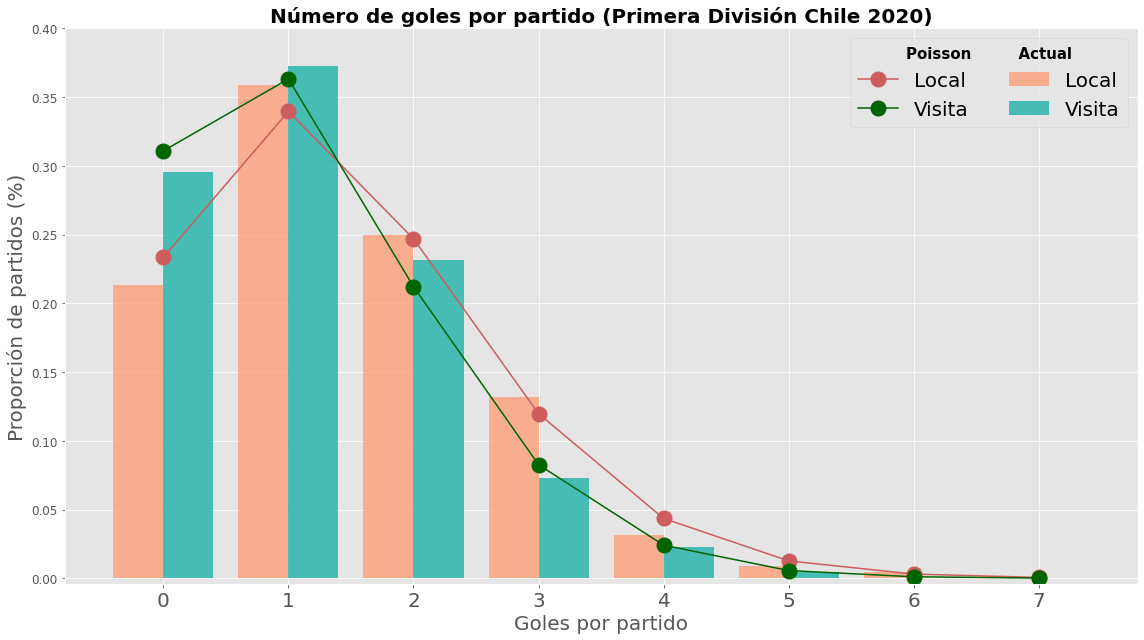

In [208]:
N_poisson = 8
poisson_pred = np.column_stack([[poisson.pmf(i, df[j].mean()) for i in range(N_poisson)] for j in ['GL','GV']])

#Graficar distribución actual de goles en el torneo
plt.hist(df[['GL','GV']].values, range(9), density = True, label = ['Local','Visita'], 
         alpha = 0.8, color=["#FFA07A", "#20B2AA"])

#Graficar predicción de goles según tasas de poisson (promedios local-visita)
pois1, = plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,0], 
                  linestyle ='-', marker = 'o', label ='Local', color ='#CD5C5C', ms = 15)
pois2, = plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,1], 
                  linestyle= '-', marker= 'o', label ='Visita', color ='#006400', ms = 15)

#Atributos del gráfico
leg = plt.legend(loc ='upper right', fontsize = 20, ncol = 2)
leg.set_title("Poisson         Actual", prop = {'size':'15', 'weight':'bold'})
plt.xticks([i-0.5 for i in range(1,9)],[i for i in range(9)], size = 20)
plt.yticks(size = 12)
plt.xlabel("Goles por partido",size=20)
plt.ylabel("Proporción de partidos (%)",size=20)
plt.title("Número de goles por partido (Primera División Chile 2020)",size=20,fontweight='bold')
plt.ylim([-0.004, 0.4])
plt.tight_layout()
plt.savefig("poisson_dist.png")
plt.show()

## Ajustar modelo

Con datos de torneo 2020, solo partidos jugados

In [209]:
df_played = df[df.Jugado == 1]
goal_model_data = pd.concat([df_played[['Local','Visita','GL']].assign(Localia=1).rename(
            columns={'Local':'Equipo','Visita':'Rival','GL':'Goles'}),
           df_played[['Visita','Local','GV']].assign(Localia=0).rename(
            columns={'Visita':'Equipo','Local':'Rival','GV':'Goles'})])

poisson_model = smf.glm(formula="Goles ~ Localia + Equipo + Rival", data = goal_model_data, 
                        family=sm.families.Poisson()).fit()
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Goles   No. Observations:                  440
Model:                            GLM   Df Residuals:                      404
Model Family:                 Poisson   Df Model:                           35
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -611.11
Date:                Sun, 27 Dec 2020   Deviance:                       435.24
Time:                        22:13:15   Pearson chi2:                     363.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -0.0432      0.261     -0.165      0.869      -0.555       0.469
Equipo[T.Audax Italiano]                0.0807      0.240      0.336      0.737      -0.391       0.552
Equipo[T.Cobresal]                     -0.0545      0.254     -0.215      0.830      -0.552       0.443
Equipo[T.Colo-Colo]                    -0.2067      0.264     -0.782      0.434      -0.725       0.311
Equipo[T.Coquimbo Unido]               -0.3332      0.271     -1.228      0.219      -0.865       0.199
Equipo[T.Curicó Unido]                 -0.1029      0.256     -0.402      0.688      -0.605       0.399
Equipo[T.Everton]                      -0.0673      0.252     -0.267      0.790      -0.561       0.427
Equipo[T.Huachipato]                   -0.1402      0.255     -0.551      0.582      -0.639       0.359
Equipo[T.Iquique]                      -0.1284      0.262     -0.491      0.623      -0.641       0.384
Equipo[T.La Serena]                    -0.2120      0.262     -0.811      0.418      -0.725       0.301
Equipo[T.O'Higgins]                    -0.0522      0.253     -0.206      0.837      -0.549       0.444
Equipo[T.Palestino]                    -0.1115      0.257     -0.434      0.664      -0.615       0.392
Equipo[T.Santiago Wanderers]            0.0405      0.246      0.165      0.869      -0.441       0.522
Equipo[T.Universidad Católica]          0.5471      0.223      2.450      0.014       0.109       0.985
Equipo[T.Universidad de Chile]          0.1876      0.238      0.787      0.432      -0.280       0.655
Equipo[T.Universidad de Concepción]    -0.0563      0.252     -0.223      0.823      -0.551       0.438
Equipo[T.Unión Española]                0.2719      0.231      1.176      0.240      -0.181       0.725
Equipo[T.Unión La Calera]               0.3534      0.234      1.510      0.131      -0.105       0.812
Rival[T.Audax Italiano]                 0.3519      0.244      1.443      0.149      -0.126       0.830
Rival[T.Cobresal]                       0.1042      0.262      0.398      0.690      -0.408       0.617
Rival[T.Colo-Colo]                      0.2767      0.250      1.106      0.269      -0.214       0.767
Rival[T.Coquimbo Unido]                 0.2282      0.251      0.909      0.363      -0.264       0.720
Rival[T.Curicó Unido]                   0.2412      0.256      0.944      0.345      -0.260       0.742
Rival[T.Everton]                        0.0934      0.260      0.359      0.720      -0.417       0.603
Rival[T.Huachipato]                     0.1387      0.258      0.537      0.591      -0.367       0.645
Rival[T.Iquique]                        0.2133      0.259      0.822      0.411      -0.295       0.722
Rival[T.La Serena]                      0.0673      0.264      0.25

## Simulación

In [210]:
np.random.seed(42)

In [211]:
N_sim = 10000
df_tabla_2020 = current_table(df, teams)
sim_poisson_local, sim_poisson_visita = poisson_tournament(df, poisson_model, N = N_sim)
df_posicion = summary_positions(sim_poisson_local, sim_poisson_visita, N_sim, teams, df_tabla_2019, df_tabla_2020)

86it [00:00, 89.32it/s]
  0%|          | 0/10000 [00:00<?, ?it/s]

0:00:01.694091


100%|██████████| 10000/10000 [1:30:01<00:00,  1.85it/s]


In [212]:
sim_poisson_local.head()

,,1,2,3,4,5,6,7,8,9,10,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000
idMatch,Local,,,,,,,,,,,,,,,,,,,,,
197,Universidad Católica,4,1,3,3,2,3,3,3,2,4,...,2,2,2,5,3,1,2,2,2,4
199,Universidad de Chile,2,1,0,2,0,2,4,2,3,2,...,0,0,0,0,1,0,0,3,1,4
203,Universidad Católica,0,2,4,2,3,1,3,2,4,2,...,5,6,3,2,3,2,5,3,1,2
206,Unión La Calera,2,4,3,2,2,2,3,3,3,0,...,6,1,5,4,3,3,1,1,3,0
207,O'Higgins,3,2,1,3,2,1,1,0,2,0,...,2,1,2,1,0,0,1,1,1,0


In [213]:
sim_poisson_visita.head()

,,1,2,3,4,5,6,7,8,9,10,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000
idMatch,Visita,,,,,,,,,,,,,,,,,,,,,
197,Santiago Wanderers,1,3,3,0,1,1,0,1,0,1,...,2,0,1,2,0,0,1,1,1,0
199,Iquique,2,1,1,0,0,0,1,0,1,0,...,1,0,1,2,0,0,1,1,0,2
203,Palestino,1,1,3,0,0,0,2,3,1,1,...,0,1,0,0,1,1,3,2,0,0
206,O'Higgins,0,0,0,1,0,2,4,2,1,2,...,1,0,0,2,0,1,1,0,2,1
207,Universidad Católica,5,0,2,3,1,0,0,2,4,5,...,2,3,3,1,0,1,4,2,3,3


In [215]:
df_desc_stats = relegation_stats(N_sim, df_posicion, poisson_model)
df_desc_stats

100%|██████████| 10000/10000 [17:44<00:00,  9.39it/s]

53 20 1362


,n_sim,Equipo,Desc,Motivo
0,1,Colo-Colo,1,Último Absoluta
1,1,Universidad de Concepción,2,Último Ponderada
2,1,Iquique,3,Partido Pen Abs vs Pen Pon
3,2,Colo-Colo,1,Último Absoluta
4,2,Universidad de Concepción,2,Último Ponderada
...,...,...,...,...
29995,9999,Universidad de Concepción,2,Último Ponderada
29996,9999,Audax Italiano,3,Partido Pen Abs vs Pen Pon
29997,10000,Colo-Colo,1,Último Absoluta
29998,10000,Iquique,2,Último Ponderada


In [216]:
prob_desc = df_desc_stats.Equipo.value_counts()/N_sim
prob_desc

Universidad de Concepción    0.8865
Iquique                      0.6706
Colo-Colo                    0.6579
Coquimbo Unido               0.3995
Audax Italiano               0.1299
La Serena                    0.0764
O'Higgins                    0.0700
Santiago Wanderers           0.0241
Cobresal                     0.0192
Curicó Unido                 0.0188
Everton                      0.0173
Universidad de Chile         0.0168
Huachipato                   0.0076
Palestino                    0.0041
Antofagasta                  0.0013
Name: Equipo, dtype: float64

In [217]:
summary_reasons = pd.pivot_table(df_desc_stats, index = "Equipo", columns = "Desc", values = "Motivo", 
                                 aggfunc = "count").fillna(0)/N_sim
summary_reasons = summary_reasons.loc[prob_desc.index]
summary_reasons["Prob Desc"] = summary_reasons["1"] + summary_reasons["2"] + summary_reasons["3"]
summary_reasons

Desc,1,2,3,Prob Desc
Universidad de Concepción,0.0294,0.6959,0.1612,0.8865
Iquique,0.0292,0.2850,0.3564,0.6706
Colo-Colo,0.5585,0.0000,0.0994,0.6579
Coquimbo Unido,0.2706,0.0000,0.1289,0.3995
Audax Italiano,0.0547,0.0000,0.0752,0.1299
La Serena,0.0129,0.0134,0.0501,0.0764
O'Higgins,0.0304,0.0000,0.0396,0.0700
Santiago Wanderers,0.0031,0.0034,0.0176,0.0241
Cobresal,0.0066,0.0001,0.0125,0.0192
Curicó Unido,0.0000,0.0007,0.0181,0.0188


In [218]:
(summary_reasons*100).to_excel("resumen_descenso.xlsx")

## Análisis del descenso: casos difusos

In [219]:
df_cd3 = cases_distribution(df_posicion)
df_cd3.head()

100%|██████████| 10000/10000 [00:41<00:00, 241.64it/s]

A = X 0.0599
A != X 0.9401
-------------------
A = X & B = Y 0.0053
A = X & B != Y 0.0546
A != X & A = Y 0.0097
A != X & A != Y 0.9304
-------------------
A = X & B != Y & B = Z 0.0035
A = X & B != Y & B != Z 0.0511
A != X & A = Y & B = X 0.002
A != X & A = Y & B != X 0.0077
A != X & A != Y & B = X 0.1362
A != X & A != Y & B != X 0.7942


,n_sim,PenPon,AntAbs,Des1,Des2,PenAbs
0,4,Universidad de Concepción,Audax Italiano,Coquimbo Unido,Iquique,Iquique
1,14,Universidad de Concepción,Everton,Audax Italiano,Iquique,Iquique
2,37,Universidad de Concepción,O'Higgins,Colo-Colo,Iquique,Iquique
3,38,Everton,Everton,O'Higgins,Iquique,Iquique
4,40,Iquique,Coquimbo Unido,Colo-Colo,Universidad de Concepción,Universidad de Concepción


In [220]:
df_cd3[df_cd3.Des2 == df_cd3.PenAbs].PenAbs.value_counts()/N_sim

Universidad de Concepción    0.0738
Iquique                      0.0538
La Serena                    0.0065
Santiago Wanderers           0.0019
Everton                      0.0002
Name: PenAbs, dtype: float64

In [221]:
(df_cd3.AntAbs.value_counts()/df_cd3.shape[0]).round(4)

Coquimbo Unido               0.2628
Audax Italiano               0.1850
Colo-Colo                    0.1263
O'Higgins                    0.1116
La Serena                    0.0815
Iquique                      0.0609
Cobresal                     0.0419
Santiago Wanderers           0.0345
Huachipato                   0.0345
Everton                      0.0250
Palestino                    0.0191
Universidad de Concepción    0.0162
Curicó Unido                 0.0007
Name: AntAbs, dtype: float64

### Prob de campeonar

In [222]:
df_posicion[(df_posicion["Posición"] == 1)&(df_posicion.Tabla == "Absoluta")].Equipo.value_counts()/N_sim

Universidad Católica    0.6952
Unión La Calera         0.2979
Unión Española          0.0067
Universidad de Chile    0.0002
Name: Equipo, dtype: float64

## Prob partido definición Colo Colo vs Universidad de Chile

In [189]:
# próximo a calcular